In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
from ema_workbench.util.utilities import load_results

In [2]:
# load results
experiment, result = load_results('uncertainty_rerun.tar.gz')
results = pd.read_csv('03_MORO_results.csv')
inputs = results.iloc[:,:32]
outcomes = results.iloc[:,32:]

In [3]:
outcomes = outcomes.rename(columns={"Expected_Damage":"Expected Damage", "Dike_Costs":"Cost for dike heigthening","RfR_Costs":"Cost for Room for the River", "Evacuation_Costs":"Cost of Evacuation", "Number_of_Deaths":"Expected number of deaths", "wl":"Minimum Waterlevel"})

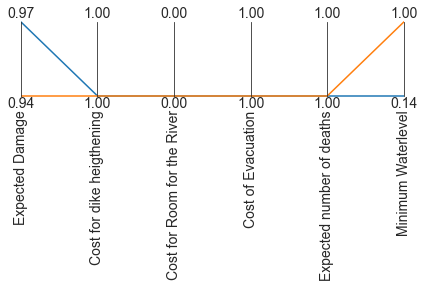

In [4]:
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.show()

In [5]:
results_pol1 = pd.DataFrame()
results_pol2 = pd.DataFrame()
results_pol1['Expected Annual Damage'] = result['Expected Annual Damage'][:1000]
results_pol2['Expected Annual Damage'] = result['Expected Annual Damage'][1000:]
results_pol1['Dike Investment Costs'] = result['Dike Investment Costs'][:1000]
results_pol2['Dike Investment Costs'] = result['Dike Investment Costs'][1000:]
results_pol1['RfR Investment Costs'] = result['RfR Investment Costs'][:1000]
results_pol2['RfR Investment Costs'] = result['RfR Investment Costs'][1000:]
results_pol1['Evacuation Costs'] = result['Evacuation Costs'][:1000]
results_pol2['Evacuation Costs'] = result['Evacuation Costs'][1000:]
results_pol1['Expected Number of Deaths'] = result['Expected Number of Deaths'][:1000]
results_pol2['Expected Number of Deaths'] = result['Expected Number of Deaths'][1000:]
results_pol1['Minimum water level full network'] = result['Minimum water level full network'][:1000]
results_pol2['Minimum water level full network'] = result['Minimum water level full network'][1000:]

objectives = ['Expected Annual Damage', 'Dike Investment Costs','RfR Investment Costs','Evacuation Costs',
              'Expected Number of Deaths','Minimum water level full network']

In [6]:
# Robustness metrics
def hurwitz(data,column_names,alpha=0):
    '''weighs off the best and worst payoffs'''
    results = {}
    
    for column_name in column_names:
        Max_value = data[column_name].max()
        Min_value = data[column_name].min()

        #calculate hurwitz coefficient as described in Arrow (1972)
        hurwitz_coef = alpha * Max_value + (1-alpha) * Min_value
        results[column_name] = hurwitz_coef
    
    
    return results

def mean_variance(data,column_names):
    '''for maximization this is defined as the mean divided by the standard deviation (Kwakkel et al, 2019)'''
    results = {}
    
    for column_name in column_names:
        mean_value = data[column_name].mean()
        std_value = data[column_name].std()
        if abs(std_value) < 0.001:
            mv_coef = 0
        else:
            mv_coef = round(mean_value/std_value, 3)
        results[column_name] = mv_coef
    
    return results

def quartile_skewedness(data,column_names):
    '''returns the quartile that contains the most observations'''
    results = {}
    Values = {}
    for column_name in column_names:
        #place all results in four equally spaced bins
        data['MyQuantileBins'] =  pd.cut(data[column_name], 4)
        values = data['MyQuantileBins'].value_counts()
        Values[column_name] = values
        #determine which quartile (bin) is overrepresented (contains the most values)
        for i in range(3):
            if max(values) == values[i]:
                #save the quartile and the percentage of values it contains in a dictionary
                results[column_name] = (i+1,(round(values[i]/values.sum(),3)))    
    return results, Values

In [9]:
#makes a dict of hurwitz values of alpha=0,0.5,1 for each column and then plots the dict
def hurwitz_results(results,objectives,policy_nr):
    HurAlpha_0 = hurwitz(results,objectives,0)
    HurAlpha_0_5 = hurwitz(results,objectives,0.5)
    HurAlpha_1 = hurwitz(results,objectives,1)
    hurlist = [HurAlpha_0,HurAlpha_0_5,HurAlpha_1]
    
    for i in objectives:
        metric = {}
        counter = 0
        for j in hurlist:
            metric['Alpha = ' + str(counter)] = j[i]
            counter += 0.5
        plt.title('Policy {} Hurwitz, '.format(policy_nr) + str(i))
        plt.bar(range(len(metric)), list(metric.values()), align='center', color = 'sienna')
        plt.xticks(range(len(metric)), list(metric.keys()))
        plt.show()

def mean_variance_results(results,objectives,policy_nr):
    Mv = mean_variance(results_pol1,objectives)
    
    plt.title('Policy {} Mean variance'.format(policy_nr))
    plt.bar(range(len(Mv)), list(Mv.values()), align='center',width = 0.4, color = 'seagreen')
    plt.xticks(range(len(Mv)), list(Mv.keys()), rotation = 20, ha='right')
    
    plt.show()
    
def quartile_skewedness_results(results,objectives,policy_nr):
    Qs, Qsval = quartile_skewedness(results_pol1,objectives)
    
    for i in objectives:
        
        Qsval[i].plot(kind='bar', color = 'steelblue')
        plt.xticks(rotation = 20, ha='right')
        plt.title('Policy {} quartile skewedness, '.format(policy_nr) + str(i) + '. Q{} dominant ({}%)'.format(Qs[i][0],Qs[i][1]*100))
        plt.show()

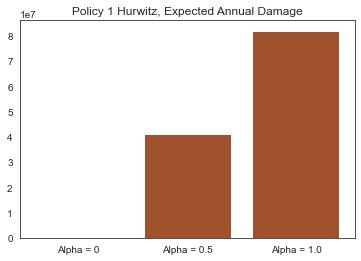

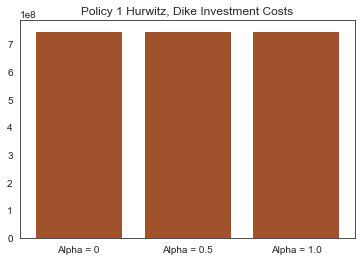

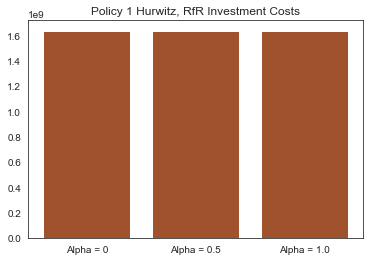

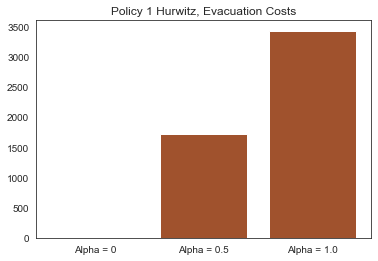

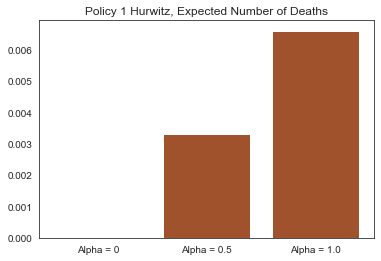

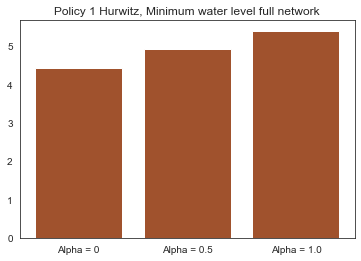

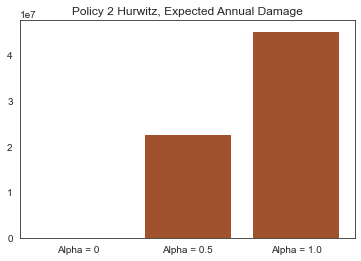

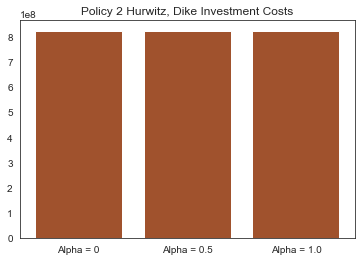

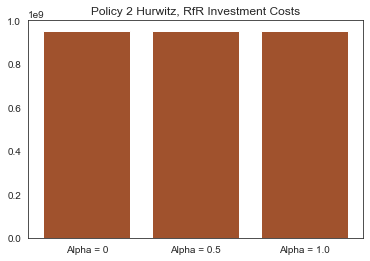

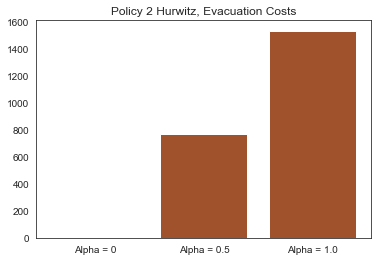

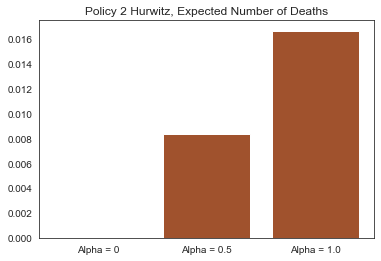

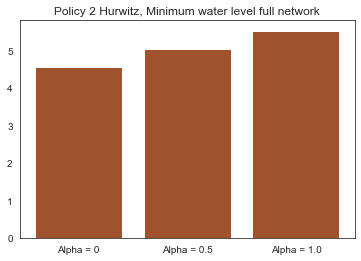

In [10]:
hurwitz_results(results_pol1,objectives,1)
hurwitz_results(results_pol2,objectives,2)

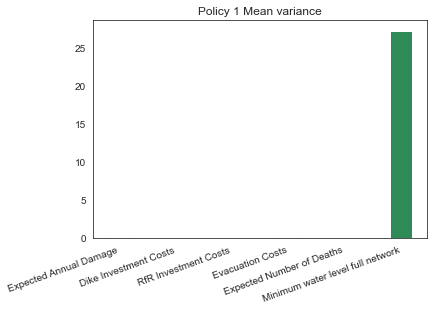

In [11]:
# Difference is so large it makes more sense to report as a table
mean_variance_results(results_pol1,objectives,1)

In [17]:
mvdict = mean_variance(results_pol1,objectives)
mvdf = pd.DataFrame(list(mvdict.items()),columns = ['Objective','Mean variance'])
mvdf

,Objective,Mean variance
0,Expected Annual Damage,0.061
1,Dike Investment Costs,0.000
2,RfR Investment Costs,0.000
3,Evacuation Costs,0.075
4,Expected Number of Deaths,0.000
5,Minimum water level full network,27.265


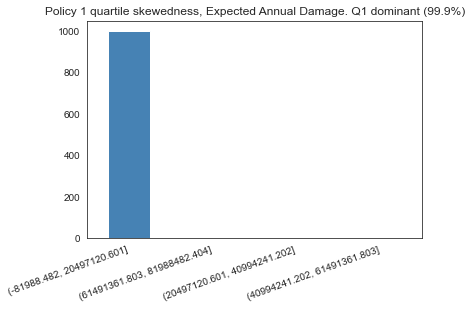

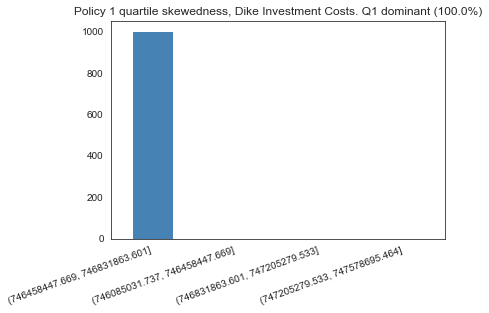

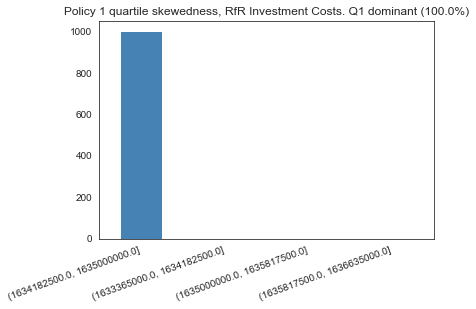

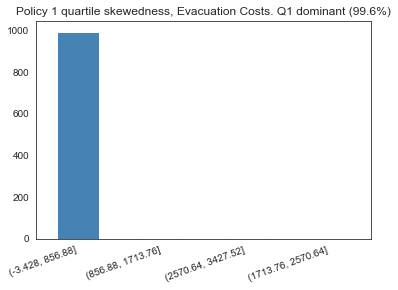

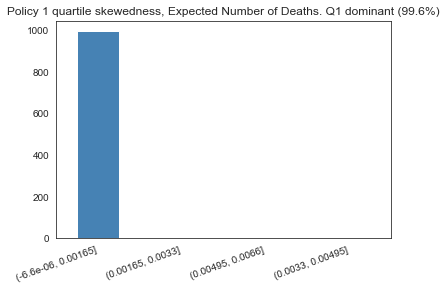

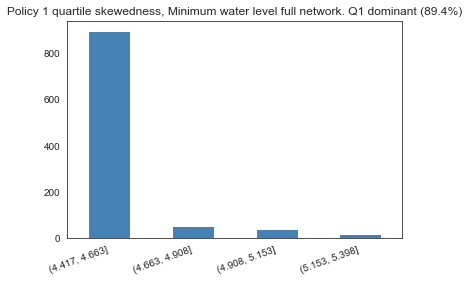

In [12]:
quartile_skewedness_results(results_pol1,objectives,1)